In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math

In [ ]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


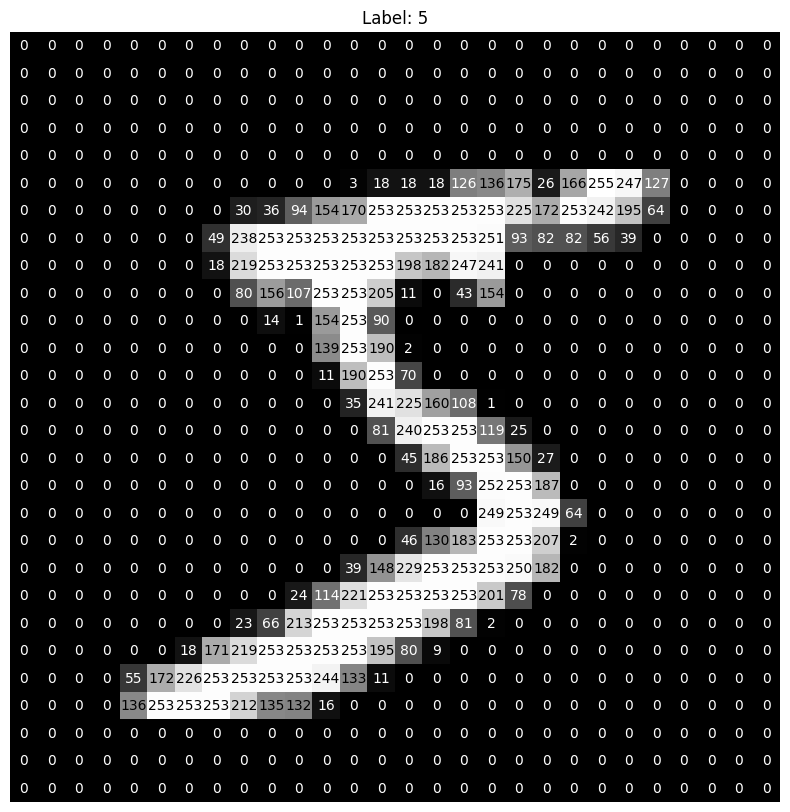

In [ ]:
 # Choose an image for visualization
image = train_images[0]
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
for i in range(28):
    for j in range(28):
        plt.text(j, i, str(image[i, j]), ha='center', va='center', color='white' if image[i, j] < 128 else 'black')
plt.title(f"Label: {train_labels[0]}")
plt.axis('off')
plt.show()

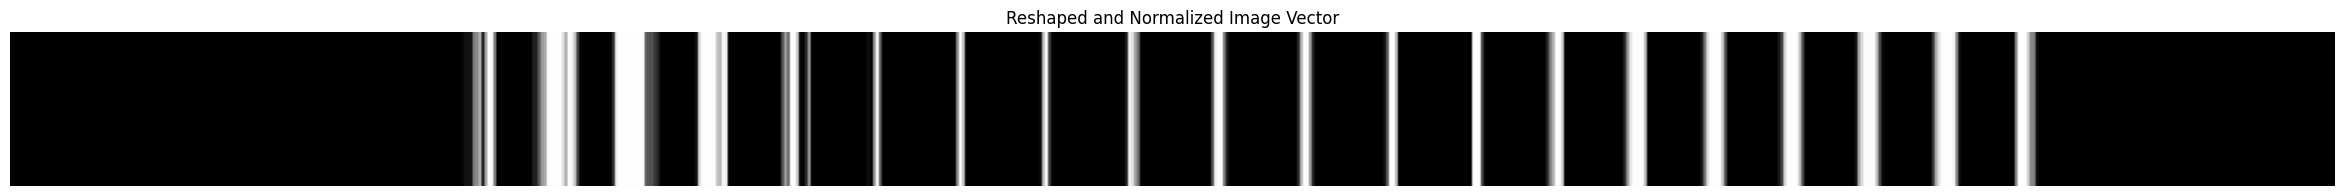

In [ ]:
# Reshape the image into a 1D vector
reshaped_image = image.reshape(-1)
# Normalize the image
normalized_image = reshaped_image / 255.0

plt.figure(figsize=(30, 2))
plt.imshow(normalized_image[np.newaxis, :], cmap='gray', aspect='auto')
plt.title("Reshaped and Normalized Image Vector")
plt.axis('off')
plt.show()

# Initializing a NN

Glorot initialization, also known as Xavier initialization, is a weight initialization technique designed to address the vanishing/exploding gradient problem commonly encountered in deep neural networks, especially those using Sigmoid or hyperbolic tangent (tanh) activation functions. The technique was introduced by Xavier Glorot and Yoshua Bengio in their 2010 paper ["Understanding the difficulty of training deep feedforward neural networks"](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf).

The idea behind Glorot initialization is to initialize the weights in such a way that the variance of the activations remains the same for both the forward and backward passes. This helps in maintaining a stable gradient flow across layers during training.

The weights $ W $ are initialized according to the formula:

$$
\text{Var}(W) = \frac{1}{n}
$$

where $ n $ is the number of input units in the neuron's layer. In practice, the weights are often sampled from a Gaussian or uniform distribution that follows this variance.

It's worth noting that while Glorot initialization is effective for Sigmoid and tanh activation functions, it may not be the best choice for other types of activations like ReLU. For ReLU activations, He initialization is often recommended.


In [ ]:
# Sigmoid activation function
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))a

In [ ]:
# Initialize parameters
def initialize_parameters(layer_sizes):
    # Set seed for reproducibility
    np.random.seed(42)

    # Dictionary to hold the weights and biases for each layer
    parameters = {}

    # Determine the number of layers in the network
    L = len(layer_sizes)

    # Loop over each layer to initialize its weights and biases
    for l in range(1, L):
        # Initialize weights using Xavier (Glorot) initialization
        # The shape ensures matrix multiplication between layers is possible
        parameters['W' + str(l)] = np.random.randn(layer_sizes[l], layer_sizes[l - 1]) * np.sqrt(1. / layer_sizes[l - 1])

        # Initialize biases to zeros for each neuron in the current layer
        parameters['b' + str(l)] = np.zeros((layer_sizes[l], 1))

    return parameters

## Forward Pass in a Neural Network

The forward pass in a neural network involves two main steps for each layer $ l $:

1. **Linear Transformation**:
   $$
   Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}
   $$

2. **Activation Function** (e.g., using sigmoid):
   $$
   A^{[l]} = \sigma(Z^{[l]})
   $$

For a deep neural network with $ L $ layers, the forward pass is executed as follows:

$$
\begin{aligned}
Z^{[1]} &= W^{[1]} A^{[0]} + b^{[1]} \\
A^{[1]} &= \sigma(Z^{[1]}) \\
Z^{[2]} &= W^{[2]} A^{[1]} + b^{[2]} \\
A^{[2]} &= \sigma(Z^{[2]}) \\
&\vdots \\
Z^{[L]} &= W^{[L]} A^{[L-1]} + b^{[L]} \\
A^{[L]} &= \sigma(Z^{[L]})
\end{aligned}
$$

Where:
- $ A^{[0]} $ is the input data.
- $ L $ is the total number of layers in the network.

The forward pass is crucial for both training the network and making predictions. The choice of activation function and the initialization of weights (as discussed in the Glorot initialization section) can have a significant impact on the performance of the network.

For a comprehensive understanding of forward propagation in deep neural networks, you may refer to the seminal paper by Yann LeCun, Yoshua Bengio, and Geoffrey Hinton, ["Deep Learning"](https://www.nature.com/articles/nature14539).



In [ ]:
# Forward propagation with dropout
def forward_propagation(X, parameters, keep_prob=1):
    # Dictionary to store activation values and pre-activation values for each layer
    caches = {}

    # Initialize the input activation as the input data
    A = X

    # Calculate the number of layers in the network
    L = len([key for key in parameters.keys() if "W" in key])

    # Dictionary to store dropout masks for each layer
    dropout_masks = {}

    # Loop through each layer to compute activations
    for l in range(1, L + 1):
        # Store the previous layer's activation
        A_prev = A

        # Compute the pre-activation value (Z) for the current layer
        Z = np.dot(parameters['W' + str(l)], A_prev) + parameters['b' + str(l)]

        # Compute the activation using the sigmoid function
        A = sigmoid(Z)

        # Implement dropout (used for regularization)
        if l < L:  # We don't apply dropout to the output layer
            # Create a dropout mask based on the keep probability
            dropout_mask = (np.random.rand(*A.shape) < keep_prob) / keep_prob  # Inverted dropout method

            # Apply dropout to the activation
            A *= dropout_mask

            # Store the dropout mask to be used during backpropagation
            dropout_masks["D" + str(l)] = dropout_mask

        # Cache the activation and pre-activation values for the current layer
        caches['A' + str(l)] = A
        caches['Z' + str(l)] = Z

    # Return the final activation, caches (for later use in backpropagation), and dropout masks
    return A, caches, dropout_masks

## Cost Computation in a Neural Network

**Cross-Entropy Cost Function**:

Binary Classification:
$$ J = -\frac{1}{m} \sum_{i=1}^{m} \left( Y^{(i)} \log(A^{[L](i)}) + (1 - Y^{(i)}) \log(1 - A^{[L](i)}) \right) $$

Multiclass Classification:
$$ J = -\frac{1}{m} \sum_{i=1}^{m} \sum_{j=1}^{C} Y_{j}^{(i)} \log(A_{j}^{[L](i)}) $$

**Mean Squared Error (MSE) for Time Series Prediction**:

$$
J = \frac{1}{m} \sum_{i=1}^{m} (Y^{(i)} - A^{[L](i)})^2
$$

Where $Y^{(i)}$ is the actual value and $A^{[L](i)}$ is the predicted value for the $i^{th}$ time series example.


**Regularization in Cost**:

$$ J_{reg} = J + \frac{\lambda}{2m} \sum_{l=1}^{L} ||W^{[l]}||^2_F $$

Where:
- $ m $ is the number of training examples.
- $ C $ is the number of classes.
- $ \lambda $ is the regularization parameter.
- $ L $ is the total number of layers.
- $ ||W^{[l]}||^2_F $ is the Frobenius norm of the weight matrix $ W^{[l]} $.


In [ ]:
# Compute cross-entropy cost with L2 regularization
def compute_cost(Y_pred, Y_true, parameters, lambd):
    # Number of training examples
    m = Y_true.shape[1]

    # Compute the cross-entropy part of the cost
    # To convert to MSE, replace the next line with: mse_cost = (1/m) * np.sum((Y_true - Y_pred)**2)
    cross_entropy_cost = (-1/m) * np.sum(Y_true * np.log(Y_pred) + (1 - Y_true) * np.log(1 - Y_pred))

    # Calculate the number of layers in the network
    L = len([key for key in parameters.keys() if "W" in key])

    # Initialize L2 regularization cost to 0
    l2_regularization_cost = 0

    # Loop through each layer to compute the L2 regularization cost
    for l in range(1, L + 1):
        l2_regularization_cost += np.sum(np.square(parameters["W" + str(l)]))

    # Scale the L2 regularization cost
    l2_regularization_cost *= (lambd / (2 * m))

    # Combine the cross-entropy cost and L2 regularization cost
    # To convert to MSE, replace the next line with: cost = mse_cost + l2_regularization_cost
    cost = cross_entropy_cost + l2_regularization_cost

    return cost

## Backward Propagation in a Neural Network

Backward propagation is the method used to compute the gradient of the loss function with respect to each parameter of the neural network.

**Chain Rule of Calculus**:

Backward propagation relies heavily on the chain rule of calculus. Given a composition of functions, the derivative of the outer function times the derivative of the inner function gives the derivative of the composition.

**Computing Gradients**:

For layer $ l $:

1. **Output Layer Gradient (for binary cross-entropy loss)**:
$$ dZ^{[L]} = A^{[L]} - Y $$

2. **Hidden Layer Gradient**:
$$ dZ^{[l]} = W^{[l+1]^T} dZ^{[l+1]} \odot g^{[l]'}(Z^{[l]}) $$
Where $ \odot $ denotes element-wise multiplication, and $ g^{[l]'} $ is the derivative of the activation function at layer $ l $.

3. **Weights and Bias Gradient**:
$$ dW^{[l]} = \frac{1}{m} dZ^{[l]} A^{[l-1]^T} $$
$$ db^{[l]} = \frac{1}{m} \sum_{i=1}^{m} dZ^{[l](i)} $$

4. **Regularization Term (for L2 regularization)**:
$$ dW^{[l]} = dW^{[l]} + \frac{\lambda}{m} W^{[l]} $$

**Updating Parameters**:

Using the gradients computed, the parameters are updated using gradient descent:
$$ W^{[l]} = W^{[l]} - \alpha dW^{[l]} $$
$$ b^{[l]} = b^{[l]} - \alpha db^{[l]} $$

Where:
- $ \alpha $ is the learning rate.
- $ m $ is the number of training examples.

Repeat the process for each layer, moving from the output layer to the first hidden layer.



In [ ]:
# Backward propagation with L2 regularization and dropout
def backward_propagation(X, Y, Y_pred, caches, parameters, lambd, dropout_masks):
    # Dictionary to hold gradients of weights and biases for each layer
    grads = {}

    # Calculate the number of layers in the network
    L = len([key for key in parameters.keys() if "W" in key])

    # Number of training examples
    m = X.shape[1]

    # Ensure the true labels have the same shape as the predicted labels
    Y = Y.reshape(Y_pred.shape)

    # Start with the gradient of the cost with respect to the output of the last layer
    dZ = Y_pred - Y
    grads["dW" + str(L)] = (1/m) * np.dot(dZ, caches["A" + str(L-1)].T) + (lambd / m) * parameters["W" + str(L)]
    grads["db" + str(L)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)

    # Loop backward through the layers to compute gradients for each layer
    for l in range(L-1, 0, -1):
        # Compute the gradient of the cost with respect to the output of the previous layer
        dA = np.dot(parameters["W" + str(l + 1)].T, dZ)

        # If dropout was applied during forward propagation, apply the same mask to the gradient
        if l in dropout_masks:
            dA *= dropout_masks["D" + str(l)]

        # Compute the gradient of the cost with respect to the pre-activation value of the current layer
        dZ = dA * (caches["A" + str(l)] * (1 - caches["A" + str(l)]))

        # Compute the gradients for the weights and biases
        grads["dW" + str(l)] = (1/m) * np.dot(dZ, caches["A" + str(l-1)].T if l != 1 else X.T) + (lambd / m) * parameters["W" + str(l)]
        grads["db" + str(l)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)

    return grads

In [ ]:
# Update parameters based on the computed gradients
def update_parameters(parameters, grads, learning_rate):
    # Calculate the number of layers in the network
    L = len([key for key in parameters.keys() if "W" in key])

    # Loop through each layer to update the weights and biases
    for l in range(1, L + 1):
        # Update the weights using the gradient for the weights and the learning rate
        parameters["W" + str(l)] -= learning_rate * grads["dW" + str(l)]

        # Update the biases using the gradient for the biases and the learning rate
        parameters["b" + str(l)] -= learning_rate * grads["db" + str(l)]

    return parameters


In [ ]:
# Function to predict the class labels for the given input data
def predict(X, parameters):
    # Use forward propagation to compute the predicted probabilities
    # Note: We set keep_prob to 1 to disable dropout during prediction
    Y_pred, _, _ = forward_propagation(X, parameters, keep_prob=1)

    # Convert the predicted probabilities to class labels by selecting the index of the highest probability
    predictions = np.argmax(Y_pred, axis=0)

    return predictions

In [ ]:
# Function to compute the accuracy of the model's predictions
def compute_accuracy(predictions, labels):
    # Compare the predicted labels with the true labels
    # The result is a boolean array where True indicates a correct prediction and False indicates an incorrect one
    correct_predictions = predictions == labels

    # Compute the mean of the boolean array (True is treated as 1 and False as 0)
    # Then, multiply by 100 to get the accuracy percentage
    accuracy = np.mean(correct_predictions) * 100

    return accuracy

In [ ]:
def train_neural_network(X, Y, layer_sizes, num_iterations, learning_rate, lambd, keep_prob, batch_size):
    # Set a random seed for reproducibility
    np.random.seed(1)

    # Initialize the weights and biases for the network
    parameters = initialize_parameters(layer_sizes)

    # Number of training examples
    m = X.shape[1]

    # Calculate the number of batches based on batch size
    num_batches = m // batch_size

    # Number of blocks in the loading bar
    num_blocks = 50

    # Loop through the specified number of training iterations (epochs)
    for i in range(num_iterations):
        # Initialize the loading bar and percentage completed
        loading_bar = ""
        percent_complete = (i / num_iterations) * 100

        # Calculate the number of blocks to represent completion
        blocks = int((percent_complete / 100) * num_blocks)

        # Generate the loading bar string
        loading_bar = "=" * blocks + ">" + "." * (num_blocks - blocks - 1)

        # Loop through each batch
        for j in range(num_batches):
            # Extract the current batch of input data and labels
            X_batch = X[:, j*batch_size : (j+1)*batch_size]
            Y_batch = Y[:, j*batch_size : (j+1)*batch_size]

            # Perform forward propagation to get predictions, intermediate values, and dropout masks
            Y_pred, caches, dropout_masks = forward_propagation(X_batch, parameters, keep_prob)

            # Compute the cost for the current batch
            cost = compute_cost(Y_pred, Y_batch, parameters, lambd)

            # Perform backward propagation to get gradients for weights and biases
            grads = backward_propagation(X_batch, Y_batch, Y_pred, caches, parameters, lambd, dropout_masks)

            # Update the weights and biases using the computed gradients
            parameters = update_parameters(parameters, grads, learning_rate)

        # Predict the labels for the entire dataset after each iteration
        predictions = predict(X, parameters)

        # Compute the accuracy of the predictions
        accuracy = compute_accuracy(predictions, train_labels)

        # Print the loading bar, cost, and accuracy in the same line
        print(f"\rIteration {i} Progress: [{loading_bar}] {percent_complete:.2f}% Cost: {cost:.4f}, Accuracy: {accuracy:.2f}%", end="")

    print()  # To ensure the next print statement appears on a new line
    # Return the trained parameters
    return parameters


In [ ]:
d  ef network_summary(layer_sizes):
    total_params = 0
    print("Layer (type)        Output Shape       Param #")
    print("===============================================")
    print(f"Input Layer        (None, {layer_sizes[0]})        0")
    for l in range(1, len(layer_sizes)):
        W_shape = (layer_sizes[l], layer_sizes[l-1])
        b_shape = (layer_sizes[l], 1)
        current_params = np.prod(W_shape) + np.prod(b_shape)
        total_params += current_params
        print(f"Dense Layer {l}     (None, {layer_sizes[l]})        {current_params}")
        print(f"    W{l}            {W_shape}")
        print(f"    b{l}            {b_shape}")
        print("-----------------------------------------------")
    print(f"Total params: {total_params}")
    print(f"Trainable params: {total_params}")
    print(f"Non-trainable params: 0")
    print()

In [ ]:
# Preprocess the training images by reshaping and normalizing
X_train = train_images.reshape(train_images.shape[0], -1).T / 255.
# Convert the training labels to one-hot encoded format
Y_train = (np.arange(10) == train_labels[:, None]).astype(np.float64).T

# Hyperparameters
# Define the layer sizes: input layer, two hidden layers, and an output layer
layer_sizes = [X_train.shape[0], 64, 32, 10]
# Number of iterations for training
num_iterations = 100
# Learning rate for the gradient descent update rule
learning_rate = 0.1
# Regularization parameter to control overfitting
lambd = 0.01
# Dropout keep probability to prevent overfitting
keep_prob = 0.8
# Number of training examples in one forward & backward pass
batch_size = 64

network_summary(layer_sizes)

# Train the network using batch gradient descent with L2 regularization and dropout
parameters = train_neural_network(X_train, Y_train, layer_sizes, num_iterations=num_iterations,
                                  learning_rate=learning_rate, lambd=lambd, keep_prob=keep_prob,
                                  batch_size=batch_size)

Layer (type)        Output Shape       Param #
Input Layer        (None, 784)        0
Dense Layer 1     (None, 64)        50240
    W1            (64, 784)
    b1            (64, 1)
-----------------------------------------------
Dense Layer 2     (None, 32)        2080
    W2            (32, 64)
    b2            (32, 1)
-----------------------------------------------
Dense Layer 3     (None, 10)        330
    W3            (10, 32)
    b3            (10, 1)
-----------------------------------------------
Total params: 52650
Trainable params: 52650
Non-trainable params: 0

Iteration 99 Progress: [=================================================>] 99.00% Cost: 1.1121, Accuracy: 95.70%


Test Accuracy: 95.31%


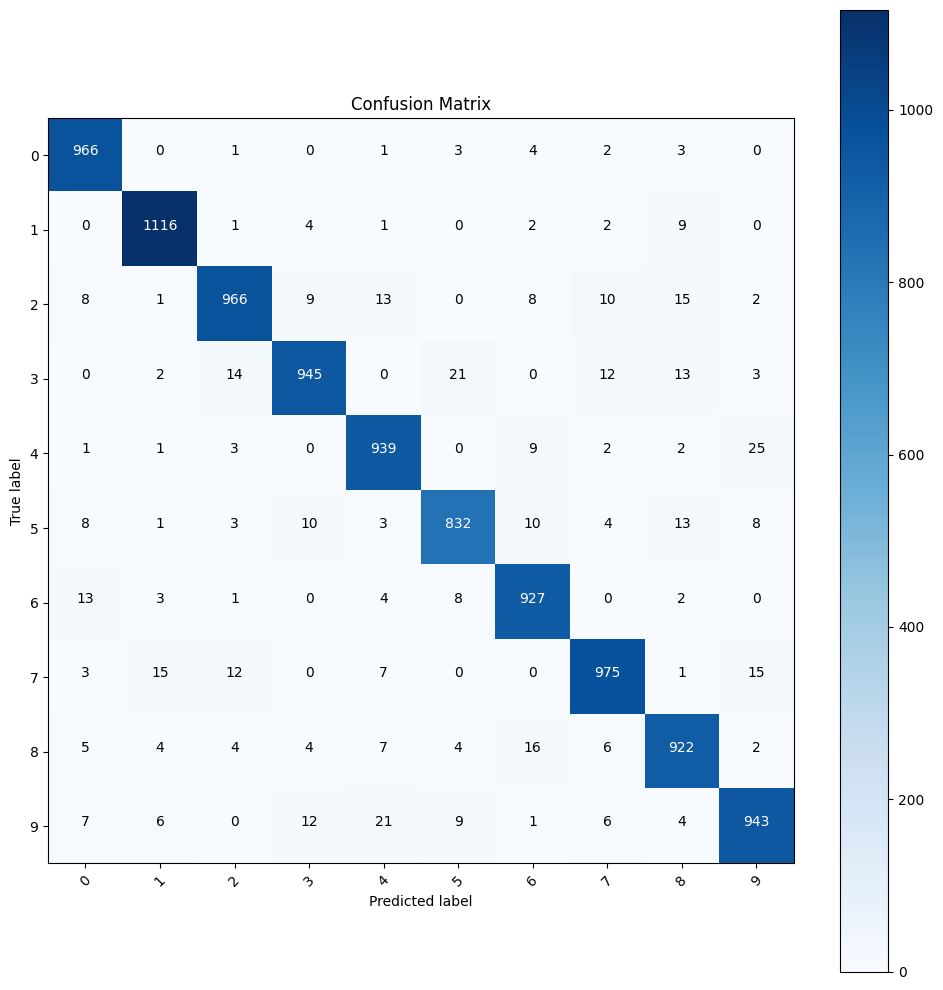

In [ ]:
# Preprocess the test images
# Reshape and normalize the test images, similar to the training images
X_test = test_images.reshape(test_images.shape[0], -1).T / 255.0

# Convert the test labels to one-hot encoded format (if needed)
Y_test = (np.arange(10) == test_labels[:, None]).astype(np.float64).T

# Use the predict() function to make predictions on the test set
test_predictions = predict(X_test, parameters)

# If you've one-hot encoded the test labels, convert them back to label format
test_labels_decoded = np.argmax(Y_test, axis=0)

# Calculate the accuracy of the model on the test set
test_accuracy = compute_accuracy(test_predictions, test_labels_decoded)

print(f'Test Accuracy: {test_accuracy:.2f}%')

# Initialize the confusion matrix with zeros
num_classes = 10  # Number of classes in the dataset
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

# Populate the confusion matrix
for true_label, predicted_label in zip(test_labels_decoded, test_predictions):
    confusion_matrix[true_label][predicted_label] += 1

# Plotting the confusion matrix using Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

# Setting tick marks and labels
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes), rotation=45)
plt.yticks(tick_marks, range(num_classes))

plt.ylabel('True label')
plt.xlabel('Predicted label')

# Displaying the actual numbers in the cells of the matrix
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, str(confusion_matrix[i, j]),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > np.max(confusion_matrix) / 2 else "black")

# Make the layout tight for better visualization
plt.tight_layout()
plt.show()


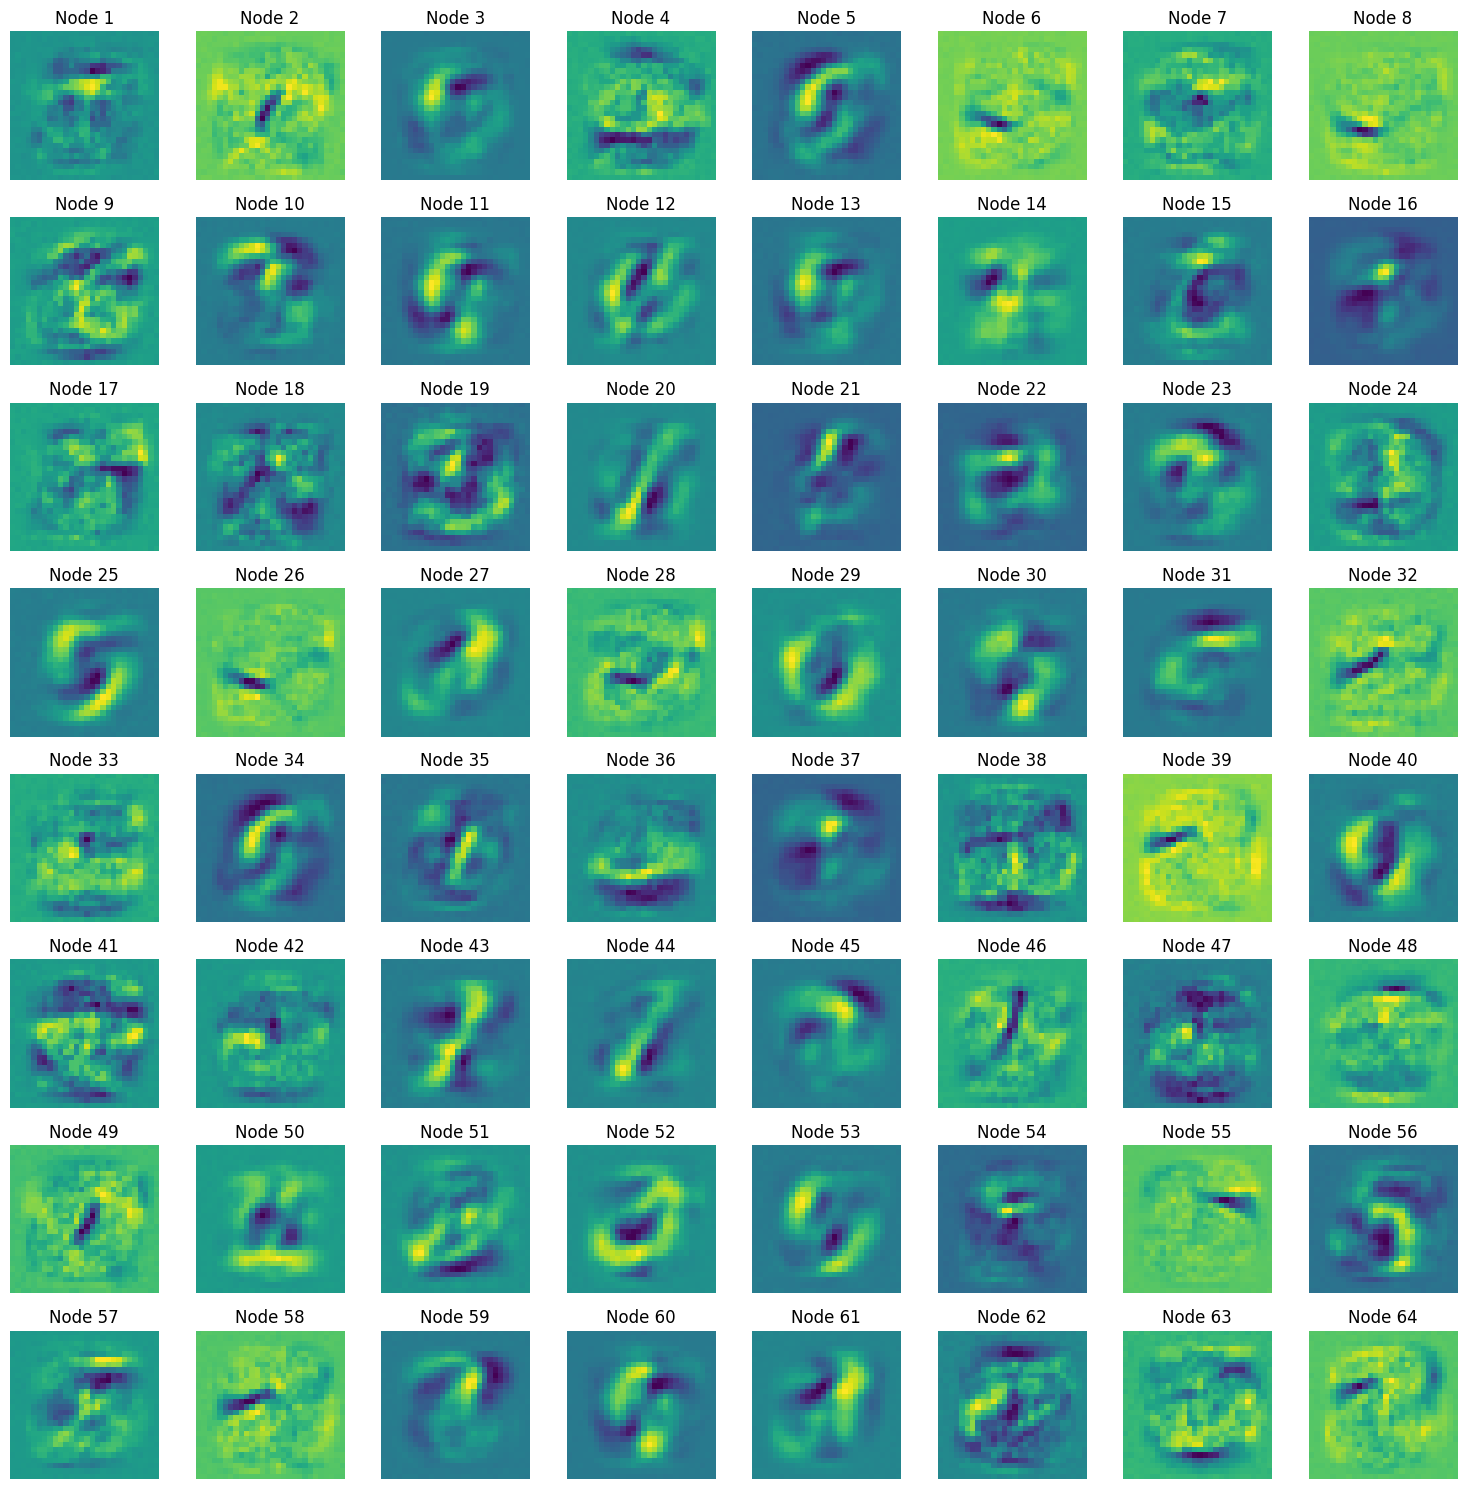

In [ ]:
# Extract the weights for the first hidden layer from the trained parameters
W1 = parameters["W1"]

# Number of nodes in the first hidden layer
num_nodes = W1.shape[0]

# Calculate the number of rows and columns for the subplot grid
num_rows = int(np.sqrt(num_nodes))
num_cols = int(np.ceil(num_nodes / num_rows))

# Create a grid of subplots for the heatmaps
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Iterate over each node in the first hidden layer
for i in range(num_nodes):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row][col]

    # Reshape the weights associated with the current node into a 28x28 grid
    weight_image = W1[i].reshape(28, 28)

    # Plot a heatmap for the current node's weights
    ax.imshow(weight_image, cmap='viridis')
    ax.set_title(f"Node {i + 1}")
    ax.axis('off')

# Remove any empty subplots if num_nodes is not a perfect square
for i in range(num_nodes, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row][col].axis('off')

# Adjust the layout of the subplots
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Preprocess the data
X_train = train_images.reshape(train_images.shape[0], -1) / 255.0
X_test = test_images.reshape(test_images.shape[0], -1) / 255.0
Y_train = tf.keras.utils.to_categorical(train_labels, 10)
Y_test = tf.keras.utils.to_categorical(test_labels, 10)

# Define the neural network
model = Sequential([
    Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01), input_shape=(784,)),  # Input layer
    Dropout(0.2),  # Dropout with 20% rate
    Dense(32, activation='sigmoid', kernel_regularizer=l2(0.01)),  # Hidden layer
    Dropout(0.2),  # Dropout with 20% rate
    Dense(10, activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam',  # Using Adam optimizer which is an advanced form of gradient descent
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=256, validation_data=(X_test, Y_test))


## Batch Normalization in a Neural Network

Batch normalization is a technique designed to automatically scale and center the inputs to activation functions in the hidden layers of a neural network. It helps in stabilizing and accelerating the training process.

### The Problem with Deep Networks

In deep networks, the distribution of activations can change during training. This phenomenon is known as **Internal Covariate Shift**. It can slow down the training process because each layer must adapt to a new distribution in every training step.

### How Batch Normalization Works

Batch normalization is applied to the input of each activation function in a layer. For each feature in a mini-batch, the mean and variance are computed and used to normalize the features. After normalization, the features are scaled and shifted using two new parameters, $ \gamma $ (Gamma) and $ \beta $ (Beta), which are learned during training.

**Normalization Step**:
$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x^{(i)}
$$
$$
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x^{(i)} - \mu)^2
$$
$$
\hat{x}^{(i)} = \frac{x^{(i)} - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

Where:
- $ \mu $ is the mean of the mini-batch.
- $ \sigma^2 $ is the variance of the mini-batch.
- $ \epsilon $ is a small constant added for numerical stability.

**Scale and Shift Step**:
$$
y^{(i)} = \gamma \hat{x}^{(i)} + \beta
$$

Where:
- $ \gamma $ is the scaling parameter.
- $ \beta $ is the shifting parameter.

### Benefits of Batch Normalization

1. **Faster Convergence**: Helps the model to converge much faster.
2. **Less Sensitive to Initialization**: The model is less sensitive to the initialization of weights.
3. **Allows Higher Learning Rates**: Larger learning rates can be used, making the training even faster.
4. **Regularization Effect**: Provides a mild regularization effect, similar to dropout.
5. **Easier Hyperparameter Tuning**: Reduces the sensitivity to the hyperparameters.

Batch normalization is generally applied before the activation function, although it can also be applied after the activation function.

For more details, you can refer to the original paper: [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)
